## NeurIPS Embedding analysis

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-05-21 15:19:42.451096: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-21 15:19:44.024998: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-21 15:19:45.615061: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
  import numpy.matlib 

In [3]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run

importlib.reload(sim.sim)
importlib.reload(sim.sim_run) 

absolute_root_path /scratch/asr655/neuroinformatics/GeneEx2Conn
absolute_root_path /scratch/asr655/neuroinformatics/GeneEx2Conn


<module 'sim.sim_run' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/sim_run.py'>

#### Check job specs

In [4]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 2.6%
RAM Usage: 5.1%
Available RAM: 1.4T
Total RAM: 1.5T
52.4G


In [5]:
print(os.environ.get("CUDA_VISIBLE_DEVICES"))

# Check available GPUs
print(f"Available GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)} - Memory Allocated: {torch.cuda.memory_allocated(i)/1024**3:.2f} GB")


None
Available GPUs: 1
GPU 0: NVIDIA H100 80GB HBM3 - Memory Allocated: 0.00 GB


In [6]:
print("XGBoost version:", xgboost.__version__)
print("cupy version:", cp.__version__)

GPUtil.getAvailable()

# if a number is seen a GPU is available
GPUtil.getGPUs()

DEVICE_ID_LIST = GPUtil.getFirstAvailable()
DEVICE_ID = DEVICE_ID_LIST[0] # grab first element from list
if DEVICE_ID != None: 
    print('GPU found', DEVICE_ID)
    use_gpu = True

    GPUtil.showUtilization()

XGBoost version: 2.0.3
cupy version: 13.1.0
GPU found 0
| ID | GPU | MEM |
------------------
|  0 |  0% |  1% |


In [7]:
torch.cuda.is_available()

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

#### Load in full dataset and compute PCA/PLS

In [8]:
from models.base_models import ModelBuild, BaseModel
from models.bilinear import BilinearLowRank, BilinearCM
from models.pls import PLSTwoStepModel, PLS_MLPDecoderModel, PLS_BilinearDecoderModel
from models.dynamic_mlp import DynamicMLP
from models.shared_encoder_models import SharedMLPEncoderModel, SharedLinearEncoderModel
from models.transformer_models import SharedSelfAttentionModel, SharedSelfAttentionCLSModel, CrossAttentionModel

from data.data_load import load_transcriptome, load_connectome, load_coords, load_network_labels
from data.data_viz import plot_connectome, plot_transcriptome
from data.data_utils import expand_X_symmetric, expand_Y_symmetric

from data.data_utils import RegionPairDataset
from torch.utils.data import Subset



In [9]:
# Load data
print("Loading data...")
X = load_transcriptome(parcellation='S400', hemisphere='both', omit_subcortical=False, sort_genes='refgenome', impute_strategy='mirror_interpolate')
Y = load_connectome(parcellation='S400', hemisphere='both', omit_subcortical=False)
coords = load_coords(parcellation='S400', hemisphere='both', omit_subcortical=False)
labels, network_labels = load_network_labels(parcellation='S400', hemisphere='both', omit_subcortical=False)

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices = ~np.isnan(X).all(axis=1)

# Create index map so we know true indices of valid data
valid_indices_values = np.where(valid_indices)[0]
valid2true_mapping = dict(enumerate(valid_indices_values))

# Subset all data using valid indices
X_valid = X[valid_indices]
Y_valid = Y[valid_indices][:, valid_indices]
coords_valid = coords[valid_indices]
labels = [labels[i] for i in range(len(labels)) if valid_indices[i]]
network_labels = network_labels[valid_indices]

# Project X to 27 PCs explaining 95% variance explained
pca = PCA(n_components=27)
X_pca = pca.fit_transform(X_valid)
print(f"X_pca shape: {X_pca.shape}")

# Project X to 10 PLS components
pls_model = PLSRegression(n_components=10, max_iter=1000, scale=True)
pls_model.fit(X_valid, Y_valid)

# Use x_rotations_ for fixed projection like in PLSEncoder
X_pls = np.matmul(X_valid, pls_model.x_rotations_)
print(f"X_pls shape: {X_pls.shape}")

# Create full region pair dataset
print("Creating RegionPairDataset...")
dataset = RegionPairDataset(
    X=X_valid,
    Y=Y_valid,
    coords=coords_valid,
    valid2true_mapping=valid2true_mapping
)

batch_size = 512
# Create dataloader with all pairs
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True  # Speed up data transfer to GPU
)

Loading data...
X_pca shape: (455, 27)
X_pls shape: (455, 10)
Creating RegionPairDataset...


Initialize best CLS model

In [10]:
from models.transformer_models import SharedSelfAttentionCLSModel
from models.transformer_models import SharedSelfAttentionModel

# Set up base model with the same hyperparameters used for training
smt_base_model = SharedSelfAttentionModel(
    input_dim=14760,   # should be 2 * num_genes
    token_encoder_dim=60,
    d_model=128,
    encoder_output_dim=10,
    nhead=4,
    num_layers=4,
    use_alibi=True,
    dropout_rate=0.2,
    transformer_dropout=0.2,
    aug_prob=0.0,
    binarize=False
)

# Load saved weights
smt_base_model.load_state_dict(torch.load("/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_base_full.pt"))
smt_base_model.eval()
smt_base_model.to("cuda")

# Set up base model with the same hyperparameters used for training
smt_base_null_model = SharedSelfAttentionModel(
    input_dim=14760,   # should be 2 * num_genes
    token_encoder_dim=60,
    d_model=128,
    encoder_output_dim=10,
    nhead=4,
    num_layers=4,
    use_alibi=True,
    dropout_rate=0.2,
    transformer_dropout=0.2,
    aug_prob=0.0,
    binarize=False
)

# Load saved weights
smt_base_null_model.load_state_dict(torch.load("/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_base_spin_full.pt"))
smt_base_null_model.eval()
smt_base_null_model.to("cuda")

# Set up model with the same hyperparameters used for training
smt_cls_model = SharedSelfAttentionCLSModel(
    input_dim=14760,   # should be 2 * num_genes
    token_encoder_dim=60,
    d_model=128,
    encoder_output_dim=10,
    nhead=4,
    num_layers=4,
    cls_init='spatial_learned',
    use_alibi=True,
    dropout_rate=0.2,
    transformer_dropout=0.2,
    aug_prob=0.0,
    binarize=False
)

# Load saved weights
smt_cls_model.load_state_dict(torch.load("/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/best_cls_model_full.pt"))
smt_cls_model.eval()
smt_cls_model.to("cuda")


# Set up model with the same hyperparameters used for training
smt_cls_null_model = SharedSelfAttentionCLSModel(
    input_dim=14760,   # should be 2 * num_genes
    token_encoder_dim=60,
    d_model=128,
    encoder_output_dim=10,
    nhead=4,
    num_layers=4,
    cls_init='spatial_learned',
    use_alibi=True,
    dropout_rate=0.2,
    transformer_dropout=0.2,
    aug_prob=0.0,
    binarize=False
)

# Load saved weights
smt_cls_null_model.load_state_dict(torch.load("/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/best_cls_model_spin_full.pt"))
smt_cls_null_model.eval()
smt_cls_null_model.to("cuda")


  warnings.warn(



SharedSelfAttentionCLSModel(
  (encoder): OptimizedModule(
    (_orig_mod): SelfAttentionCLSEncoder(
      (input_projection): Linear(in_features=60, out_features=128, bias=True)
      (coord_to_cls): Linear(in_features=3, out_features=128, bias=True)
      (layers): ModuleList(
        (0-3): 4 x FastSelfAttentionBlock(
          (qkv_proj): Linear(in_features=128, out_features=384, bias=True)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (attn_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (ffn): Sequential(
            (0): Linear(in_features=128, out_features=512, bias=True)
            (1): ReLU()
            (2): Linear(in_features=512, out_features=128, bias=True)
            (3): Dropout(p=0.2, inplace=False)
          )
          (ffn_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
      )
      (output_projection): Linear(in_features=128, out_features=10, bias=True)
    )
  )
  (deep_layers): Sequential(
    (

Subset data loader to grab region-wise embeddings

In [11]:
from torch.utils.data import Subset

# only 1000 indices are necessary to capture all unique coordinate combinations
subset_indices = list(range(1000))
subset_dataset = Subset(dataset, subset_indices)

subset_loader = DataLoader(
    subset_dataset,
    batch_size=256,            # Smaller batch to avoid GPU memory overflow
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

Compute embeddings for UKBB from SMT base and CLS model

In [12]:
base_embeddings = []
cls_embeddings = []
base_null_embeddings = []
cls_null_embeddings = []
seen_coords = set()

smt_base_model.eval()
smt_cls_model.eval()
smt_base_null_model.eval()
smt_cls_null_model.eval()

with torch.no_grad():
    for batch_X, batch_y, batch_coords, _ in subset_loader:
        batch_X = batch_X.to("cuda")
        batch_coords = batch_coords.to("cuda")

        x_i, x_j = torch.chunk(batch_X, chunks=2, dim=1)
        coords_i, coords_j = torch.chunk(batch_coords, chunks=2, dim=1)

        # Process each unique coordinate in the batch
        for x, coords in [(x_i, coords_i), (x_j, coords_j)]:
            for i in range(len(coords)):
                coord_tuple = tuple(coords[i].cpu().numpy())
                if coord_tuple not in seen_coords:
                    # Get encoded region embeddings from both models for new coordinate
                    base_emb = smt_base_model.encoder(x[i:i+1])  # Base model takes only x
                    cls_emb = smt_cls_model.encoder(x[i:i+1], coords[i:i+1])  # CLS model takes x and coords
                    base_null_emb = smt_base_null_model.encoder(x[i:i+1])  # Null base model takes only x
                    cls_null_emb = smt_cls_null_model.encoder(x[i:i+1], coords[i:i+1])  # Null CLS model takes x and coords
                    
                    base_embeddings.append(base_emb.cpu())
                    cls_embeddings.append(cls_emb.cpu())
                    base_null_embeddings.append(base_null_emb.cpu())
                    cls_null_embeddings.append(cls_null_emb.cpu())
                    seen_coords.add(coord_tuple)

# Stack all embeddings
base_embeddings = torch.cat(base_embeddings, dim=0).numpy()
cls_embeddings = torch.cat(cls_embeddings, dim=0).numpy()
base_null_embeddings = torch.cat(base_null_embeddings, dim=0).numpy()
cls_null_embeddings = torch.cat(cls_null_embeddings, dim=0).numpy()
print(base_embeddings.shape, cls_embeddings.shape, base_null_embeddings.shape, cls_null_embeddings.shape)


  warnings.warn(



(455, 1230) (455, 1240) (455, 1230) (455, 1240)


  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



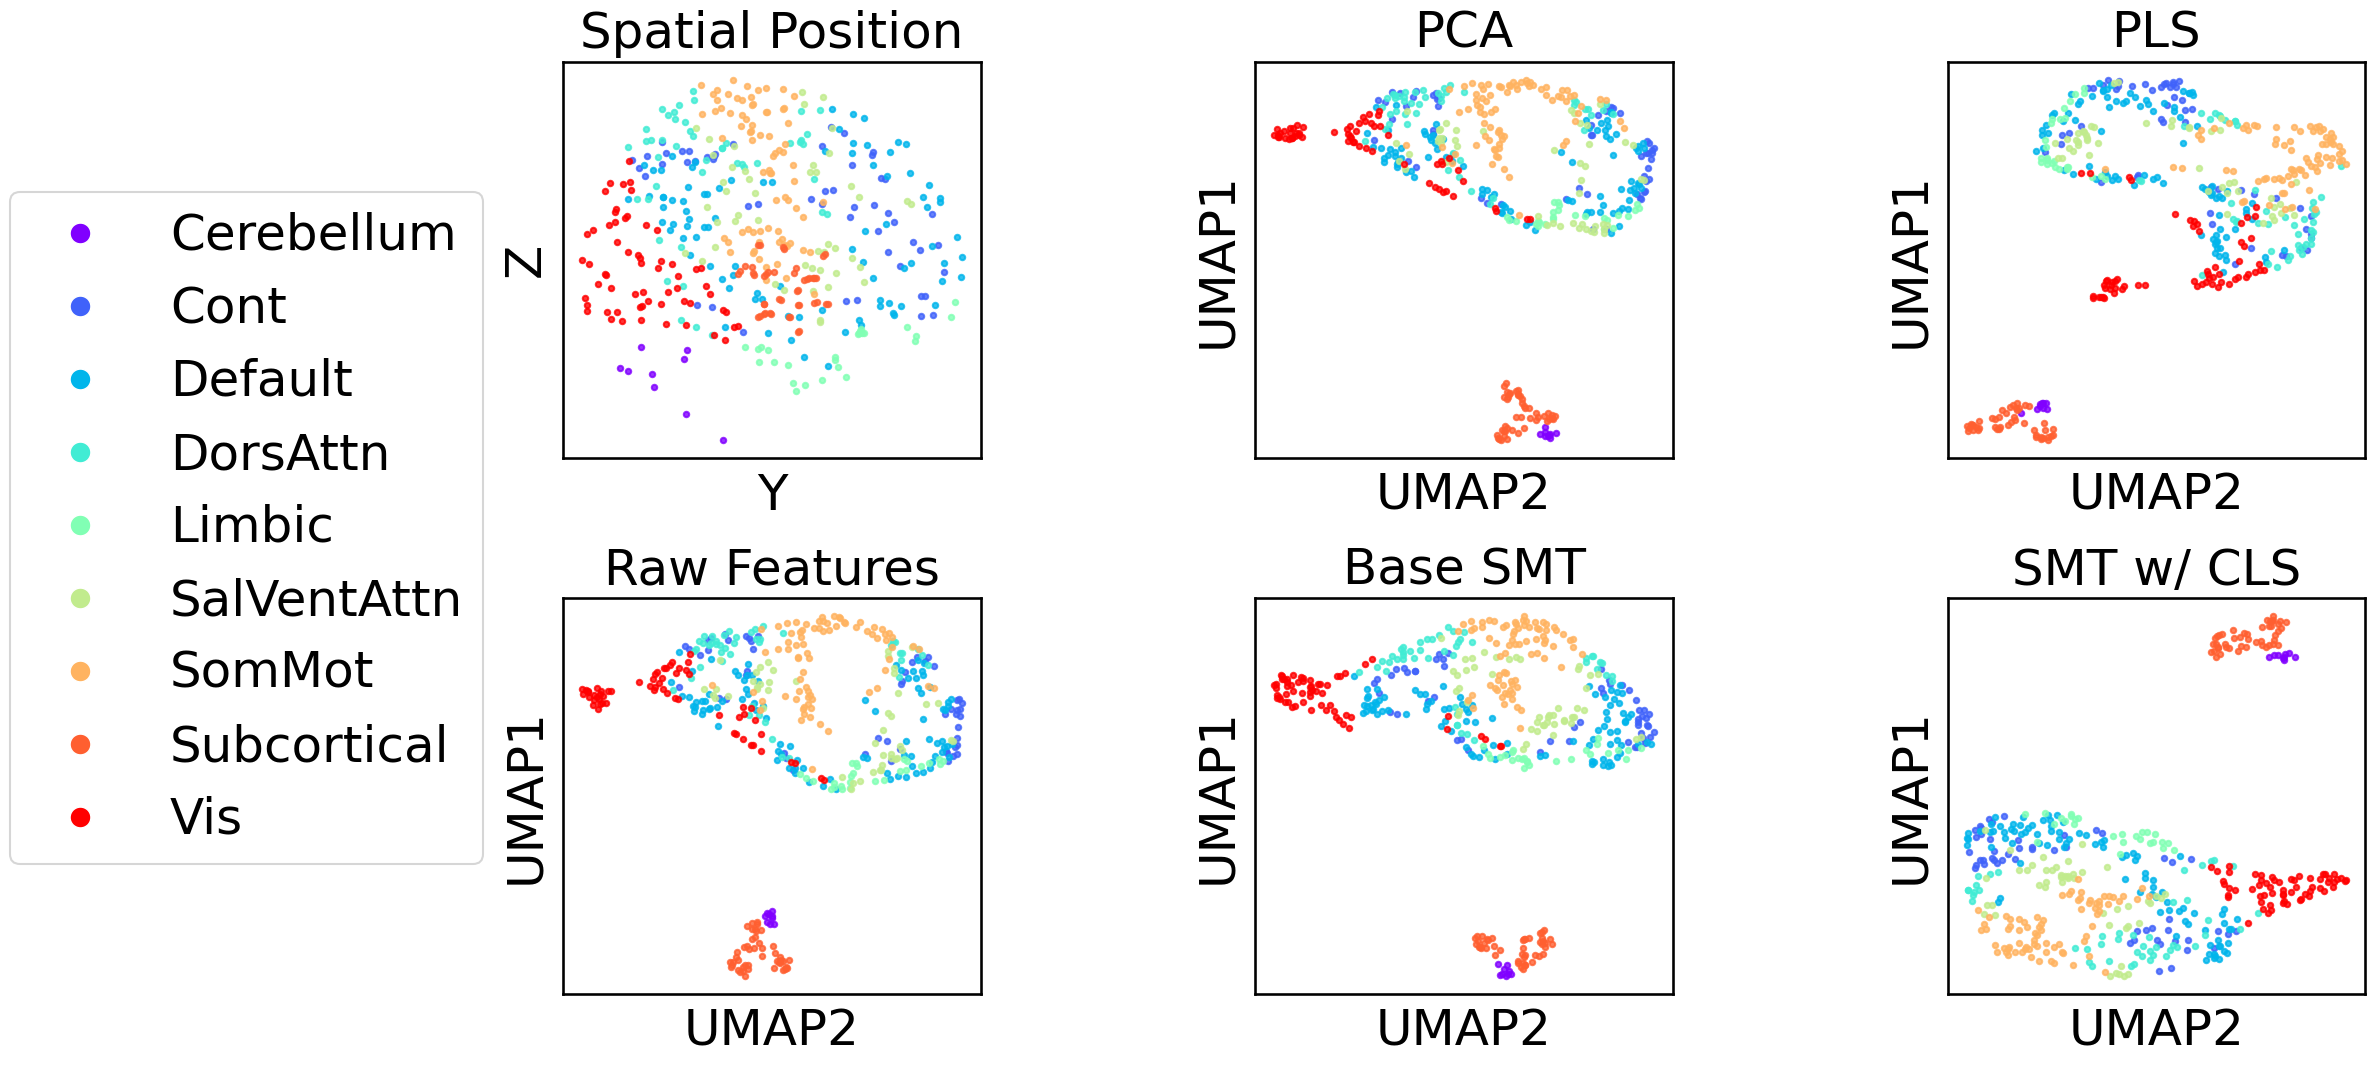

In [13]:
# Set global font size
FONTSIZE = 36

# Set global scatter params
SCATTER_PARAMS = dict(alpha=0.8, s=15)

# Import UMAP
import umap

# Create separate UMAP reducers with consistent parameters for each feature type
umap_params = dict(n_components=2, random_state=42, n_neighbors=15, spread=2.0, min_dist=0.5)
umap_reducer_base = umap.UMAP(**umap_params)
umap_reducer_cls = umap.UMAP(**umap_params)
umap_reducer_base_null = umap.UMAP(**umap_params)
umap_reducer_cls_null = umap.UMAP(**umap_params)
umap_reducer_raw = umap.UMAP(**umap_params)
umap_reducer_pca = umap.UMAP(**umap_params)
umap_reducer_pls = umap.UMAP(**umap_params)

# Create UMAP embeddings for each feature type
base_2d = umap_reducer_base.fit_transform(base_embeddings)
cls_2d = umap_reducer_cls.fit_transform(cls_embeddings)
base_null_2d = umap_reducer_base_null.fit_transform(base_null_embeddings)
cls_null_2d = umap_reducer_cls_null.fit_transform(cls_null_embeddings)
X_umap = umap_reducer_raw.fit_transform(X_valid)
pca_umap = umap_reducer_pca.fit_transform(X_pca)
pls_umap = umap_reducer_pls.fit_transform(X_pls)

# Get unique networks for coloring
unique_networks = np.unique(network_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_networks)))
network_to_color = dict(zip(unique_networks, colors))

# Create color array based on network labels
point_colors = np.array([network_to_color[label] for label in network_labels])

# First figure: Main embeddings
fig1 = plt.figure(figsize=(24, 11))
gs1 = fig1.add_gridspec(2, 4, width_ratios=[0.2, 1, 1, 1])

# Create axes for plots
axs1 = []
for row in range(2):
    for col in range(1, 4):  # Skip first column for legend
        axs1.append(fig1.add_subplot(gs1[row, col]))

# First row: Spatial, PCA, PLS
# Plot coordinates
for network, color in zip(unique_networks, colors):
    mask = network_labels == network
    axs1[0].scatter(coords_valid[mask, 1], coords_valid[mask, 2], 
                   color=color, **SCATTER_PARAMS)
axs1[0].set_title('Spatial Position', fontsize=FONTSIZE, pad=10)
axs1[0].set_xlabel('Y', fontsize=FONTSIZE, labelpad=10)
axs1[0].set_ylabel('Z', fontsize=FONTSIZE, labelpad=10)
axs1[0].set_xticks([])
axs1[0].set_yticks([])

# Plot PCA UMAP
for network, color in zip(unique_networks, colors):
    mask = network_labels == network
    axs1[1].scatter(pca_umap[mask, 1], pca_umap[mask, 0],
                   color=color, **SCATTER_PARAMS)
axs1[1].set_title('PCA', fontsize=FONTSIZE, pad=10)
axs1[1].set_xlabel('UMAP2', fontsize=FONTSIZE, labelpad=10)
axs1[1].set_ylabel('UMAP1', fontsize=FONTSIZE, labelpad=10)
axs1[1].set_xticks([])
axs1[1].set_yticks([])

# Plot PLS UMAP
for network, color in zip(unique_networks, colors):
    mask = network_labels == network
    axs1[2].scatter(pls_umap[mask, 1], pls_umap[mask, 0],
                   color=color, **SCATTER_PARAMS)
axs1[2].set_title('PLS', fontsize=FONTSIZE, pad=10)
axs1[2].set_xlabel('UMAP2', fontsize=FONTSIZE, labelpad=10)
axs1[2].set_ylabel('UMAP1', fontsize=FONTSIZE, labelpad=10)
axs1[2].set_xticks([])
axs1[2].set_yticks([])

# Second row: Raw features, Base SMT, SMT w/ CLS
# Plot UMAP of raw features
for network, color in zip(unique_networks, colors):
    mask = network_labels == network
    axs1[3].scatter(X_umap[mask, 1], X_umap[mask, 0],
                   color=color, **SCATTER_PARAMS)
axs1[3].set_title('Raw Features', fontsize=FONTSIZE, pad=10)
axs1[3].set_xlabel('UMAP2', fontsize=FONTSIZE, labelpad=10)
axs1[3].set_ylabel('UMAP1', fontsize=FONTSIZE, labelpad=10)
axs1[3].set_xticks([])
axs1[3].set_yticks([])
# Plot UMAP of base embeddings
for network, color in zip(unique_networks, colors):
    mask = network_labels == network
    axs1[4].scatter(-base_2d[mask, 1], base_2d[mask, 0],
                   color=color, **SCATTER_PARAMS)
axs1[4].set_title('Base SMT', fontsize=FONTSIZE, pad=10)
axs1[4].set_xlabel('UMAP2', fontsize=FONTSIZE, labelpad=10)
axs1[4].set_ylabel('UMAP1', fontsize=FONTSIZE, labelpad=10)
axs1[4].set_xticks([])
axs1[4].set_yticks([])

# Plot UMAP of CLS embeddings
for network, color in zip(unique_networks, colors):
    mask = network_labels == network
    axs1[5].scatter(cls_2d[mask, 1], cls_2d[mask, 0],
                   color=color, **SCATTER_PARAMS)
axs1[5].set_title('SMT w/ CLS', fontsize=FONTSIZE, pad=10)
axs1[5].set_xlabel('UMAP2', fontsize=FONTSIZE, labelpad=10)
axs1[5].set_ylabel('UMAP1', fontsize=FONTSIZE, labelpad=10)
axs1[5].set_xticks([])
axs1[5].set_yticks([])

# Create legend elements
legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                            markerfacecolor=color,
                            label=network,
                            markersize=15)
                  for network, color in zip(unique_networks, colors)]

# Add legend in the first column
legend_ax = fig1.add_subplot(gs1[:, 0])
legend_ax.axis('off')
legend_ax.legend(handles=legend_elements, loc='center', fontsize=FONTSIZE)

plt.tight_layout()

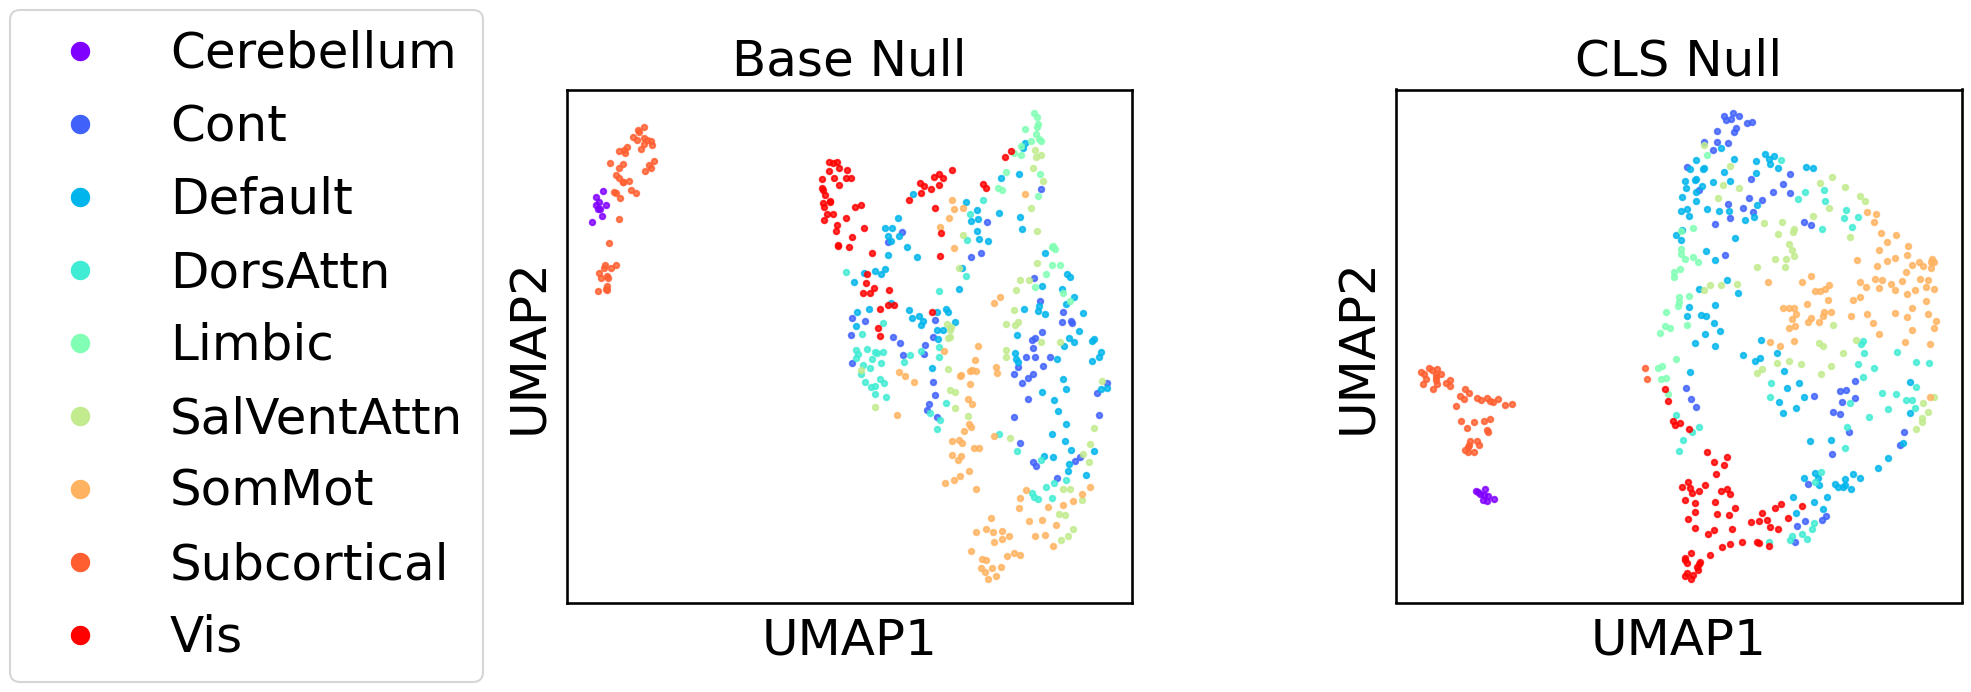

In [14]:
# Second figure: Null embeddings
fig2 = plt.figure(figsize=(20, 7))
gs2 = fig2.add_gridspec(1, 3, width_ratios=[0.2, 1, 1])

# Create axes for null plots
ax_null_base = fig2.add_subplot(gs2[0, 1])
ax_null_cls = fig2.add_subplot(gs2[0, 2])

# Plot UMAP of base null embeddings
for network, color in zip(unique_networks, colors):
    mask = network_labels == network
    ax_null_base.scatter(base_null_2d[mask, 0], base_null_2d[mask, 1],
                        color=color, **SCATTER_PARAMS)
ax_null_base.set_title('Base Null', fontsize=FONTSIZE, pad=10)
ax_null_base.set_xlabel('UMAP1', fontsize=FONTSIZE, labelpad=10)
ax_null_base.set_ylabel('UMAP2', fontsize=FONTSIZE, labelpad=10)
ax_null_base.set_xticks([])
ax_null_base.set_yticks([])

# Plot UMAP of CLS null embeddings
for network, color in zip(unique_networks, colors):
    mask = network_labels == network
    ax_null_cls.scatter(cls_null_2d[mask, 0], cls_null_2d[mask, 1],
                       color=color, **SCATTER_PARAMS)
ax_null_cls.set_title('CLS Null', fontsize=FONTSIZE, pad=10)
ax_null_cls.set_xlabel('UMAP1', fontsize=FONTSIZE, labelpad=10)
ax_null_cls.set_ylabel('UMAP2', fontsize=FONTSIZE, labelpad=10)
ax_null_cls.set_xticks([])
ax_null_cls.set_yticks([])

# Add legend to null plot
legend_ax2 = fig2.add_subplot(gs2[0, 0])
legend_ax2.axis('off')
legend_ax2.legend(handles=legend_elements, loc='center', fontsize=FONTSIZE)

plt.tight_layout()

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



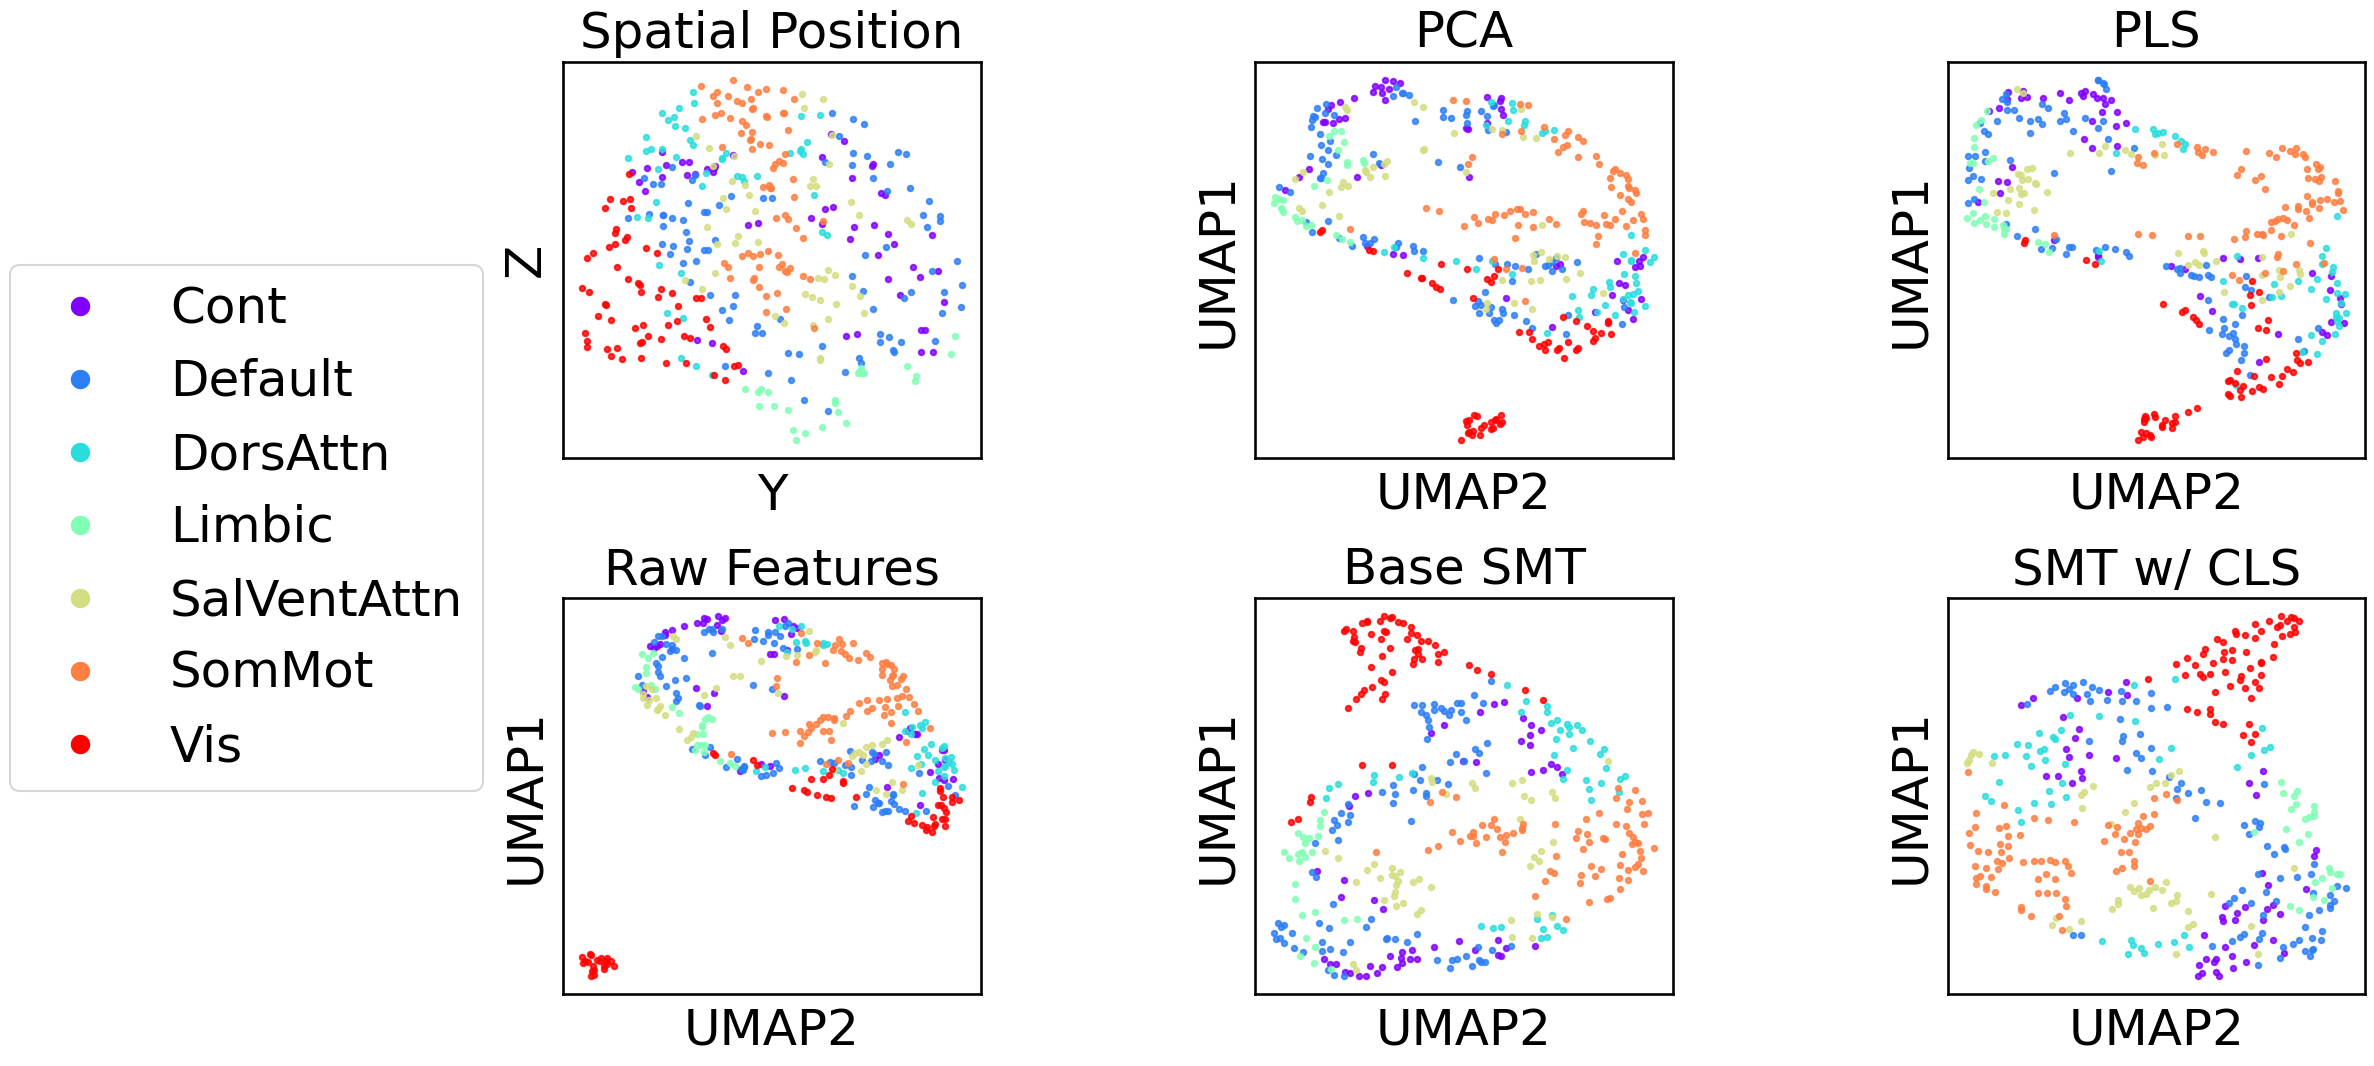

In [15]:
# Set global font size
FONTSIZE = 36

# Set global scatter params
SCATTER_PARAMS = dict(alpha=0.8, s=15)

# Import UMAP
import umap

# Filter out subcortical and cerebellum nodes
cortical_mask = ~np.isin(network_labels, ['Subcortical', 'Cerebellum'])

# Create separate UMAP reducers with consistent parameters for each feature type
umap_params = dict(n_components=2, random_state=42, n_neighbors=15, spread=2.0, min_dist=0.5)
umap_reducer_base = umap.UMAP(**umap_params)
umap_reducer_cls = umap.UMAP(**umap_params)
umap_reducer_base_null = umap.UMAP(**umap_params)
umap_reducer_cls_null = umap.UMAP(**umap_params)
umap_reducer_raw = umap.UMAP(**umap_params)
umap_reducer_pca = umap.UMAP(**umap_params)
umap_reducer_pls = umap.UMAP(**umap_params)

# Create UMAP embeddings for each feature type using only cortical nodes
base_2d = umap_reducer_base.fit_transform(base_embeddings[cortical_mask])
cls_2d = umap_reducer_cls.fit_transform(cls_embeddings[cortical_mask])
base_null_2d = umap_reducer_base_null.fit_transform(base_null_embeddings[cortical_mask])
cls_null_2d = umap_reducer_cls_null.fit_transform(cls_null_embeddings[cortical_mask])
X_umap = umap_reducer_raw.fit_transform(X_valid[cortical_mask])
pca_umap = umap_reducer_pca.fit_transform(X_pca[cortical_mask])
pls_umap = umap_reducer_pls.fit_transform(X_pls[cortical_mask])

# Get unique networks for coloring (excluding subcortical and cerebellum)
unique_networks = np.unique(network_labels[cortical_mask])
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_networks)))
network_to_color = dict(zip(unique_networks, colors))

# Create color array based on network labels
point_colors = np.array([network_to_color[label] for label in network_labels[cortical_mask]])

# First figure: Main embeddings
fig1 = plt.figure(figsize=(24, 11))
gs1 = fig1.add_gridspec(2, 4, width_ratios=[0.2, 1, 1, 1])

# Create axes for plots
axs1 = []
for row in range(2):
    for col in range(1, 4):  # Skip first column for legend
        axs1.append(fig1.add_subplot(gs1[row, col]))

# First row: Spatial, PCA, PLS
# Plot coordinates
for network, color in zip(unique_networks, colors):
    mask = network_labels[cortical_mask] == network
    axs1[0].scatter(coords_valid[cortical_mask][mask, 1], coords_valid[cortical_mask][mask, 2], 
                   color=color, **SCATTER_PARAMS)
axs1[0].set_title('Spatial Position', fontsize=FONTSIZE, pad=10)
axs1[0].set_xlabel('Y', fontsize=FONTSIZE, labelpad=10)
axs1[0].set_ylabel('Z', fontsize=FONTSIZE, labelpad=10)
axs1[0].set_xticks([])
axs1[0].set_yticks([])

# Plot PCA UMAP
for network, color in zip(unique_networks, colors):
    mask = network_labels[cortical_mask] == network
    axs1[1].scatter(pca_umap[mask, 1], pca_umap[mask, 0],
                   color=color, **SCATTER_PARAMS)
axs1[1].set_title('PCA', fontsize=FONTSIZE, pad=10)
axs1[1].set_xlabel('UMAP2', fontsize=FONTSIZE, labelpad=10)
axs1[1].set_ylabel('UMAP1', fontsize=FONTSIZE, labelpad=10)
axs1[1].set_xticks([])
axs1[1].set_yticks([])

# Plot PLS UMAP
for network, color in zip(unique_networks, colors):
    mask = network_labels[cortical_mask] == network
    axs1[2].scatter(pls_umap[mask, 1], pls_umap[mask, 0],
                   color=color, **SCATTER_PARAMS)
axs1[2].set_title('PLS', fontsize=FONTSIZE, pad=10)
axs1[2].set_xlabel('UMAP2', fontsize=FONTSIZE, labelpad=10)
axs1[2].set_ylabel('UMAP1', fontsize=FONTSIZE, labelpad=10)
axs1[2].set_xticks([])
axs1[2].set_yticks([])

# Second row: Raw features, Base SMT, SMT w/ CLS
# Plot UMAP of raw features
for network, color in zip(unique_networks, colors):
    mask = network_labels[cortical_mask] == network
    axs1[3].scatter(X_umap[mask, 1], X_umap[mask, 0],
                   color=color, **SCATTER_PARAMS)
axs1[3].set_title('Raw Features', fontsize=FONTSIZE, pad=10)
axs1[3].set_xlabel('UMAP2', fontsize=FONTSIZE, labelpad=10)
axs1[3].set_ylabel('UMAP1', fontsize=FONTSIZE, labelpad=10)
axs1[3].set_xticks([])
axs1[3].set_yticks([])

# Plot UMAP of base embeddings
for network, color in zip(unique_networks, colors):
    mask = network_labels[cortical_mask] == network
    axs1[4].scatter(-base_2d[mask, 1], base_2d[mask, 0],
                   color=color, **SCATTER_PARAMS)
axs1[4].set_title('Base SMT', fontsize=FONTSIZE, pad=10)
axs1[4].set_xlabel('UMAP2', fontsize=FONTSIZE, labelpad=10)
axs1[4].set_ylabel('UMAP1', fontsize=FONTSIZE, labelpad=10)
axs1[4].set_xticks([])
axs1[4].set_yticks([])

# Plot UMAP of CLS embeddings
for network, color in zip(unique_networks, colors):
    mask = network_labels[cortical_mask] == network
    axs1[5].scatter(cls_2d[mask, 1], cls_2d[mask, 0],
                   color=color, **SCATTER_PARAMS)
axs1[5].set_title('SMT w/ CLS', fontsize=FONTSIZE, pad=10)
axs1[5].set_xlabel('UMAP2', fontsize=FONTSIZE, labelpad=10)
axs1[5].set_ylabel('UMAP1', fontsize=FONTSIZE, labelpad=10)
axs1[5].set_xticks([])
axs1[5].set_yticks([])

# Create legend elements
legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                            markerfacecolor=color,
                            label=network,
                            markersize=15)
                  for network, color in zip(unique_networks, colors)]

# Add legend in the first column
legend_ax = fig1.add_subplot(gs1[:, 0])
legend_ax.axis('off')
legend_ax.legend(handles=legend_elements, loc='center', fontsize=FONTSIZE)

plt.tight_layout()